In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [13]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [19]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [21]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [22]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [23]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
ct = (calc_temps('2016-01-01', '2016-12-31'))

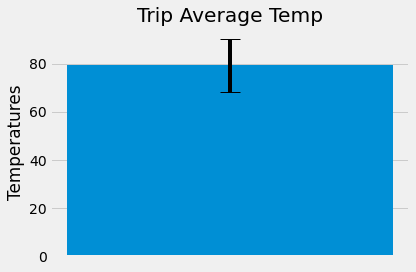

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(ct, columns=['min_temp', 'avg_temp', 'max_temp'])
y_err = df.max_temp - df.min_temp

fig, ax = plt.subplots()
# ax.set_xticks(x_pos)

# Define Data
x = np.arange(1)
y = df.avg_temp
ax.bar(x,y, yerr=y_err, capsize=10)

ax.set_title("Trip Average Temp")
ax.set_ylabel("Temperatures")
plt.gca().axes.get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig("Images/Trip-avg-temp-year.png")
plt.show()

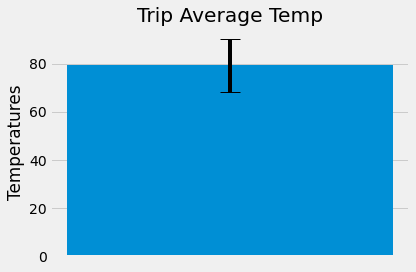

In [29]:
ct = (calc_temps('2017-08-01', '2017-08-07'))
df = pd.DataFrame(ct, columns=['min_temp', 'avg_temp', 'max_temp'])
y_err = df.max_temp - df.min_temp

fig, ax = plt.subplots()
# ax.set_xticks(x_pos)

# Define Data
x = np.arange(1)
y = df.avg_temp
ax.bar(x,y, yerr=y_err, capsize=10)

ax.set_title("Trip Average Temp")
ax.set_ylabel("Temperatures")
plt.gca().axes.get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig("Images/Trip-avg-temp-range.png")
plt.show()

### Daily Rainfall Average

In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
start_date = '2017-08-01'
end_date = '2017-08-07'

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, func.avg(Measurement.prcp)).\
           filter(Measurement.date >= start_date).\
           filter(Measurement.date <= end_date).\
           group_by(Measurement.station).\
           order_by(func.avg(Measurement.prcp).desc()).all()



rainfalldf = pd.DataFrame(rainfall, columns=['Station', 'Average Temperature'])
rainfalldf

,Station,Average Temperature
0,USC00516128,0.120000
1,USC00514830,0.036667
2,USC00519281,0.020000
3,USC00519397,0.005714
4,USC00519523,0.000000


### Daily Temperature Normals

In [31]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [148]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-22'

# Use the start and end date to create a range of dates
daterange = pd.date_range(start_date, end_date).tolist()
dateindex = pd.date_range(start_date, end_date)

 # Strip off the year and save a list of strings in the format %m-%d
md = dateindex.strftime('%m-%d')

# Get values from function 
for i in range(len(md)):
        dn = daily_normals(md[i])
        [dns] =  dn #unpack list to append to list
        normals.append(dns)

normal_rows = [{'Minimum':normal[0], 'Average':normal[1],'Max':normal[2]}
                for normal in normals] ## This gets only list index [6] values 

In [149]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normalsdf = pd.DataFrame(normal_rows)
normalsdf['Date'] = md
normalsdf.set_index('Date', inplace=True)
normalsdf

,Minimum,Average,Max
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0
08-08,68.0,76.557692,83.0
08-09,69.0,75.980392,81.0


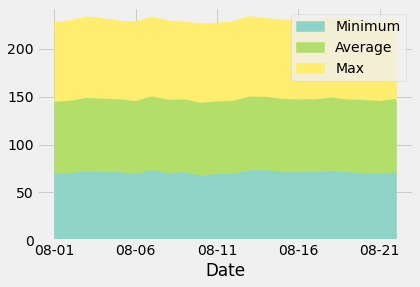

In [152]:
# Plot the daily normals as an area
normalsdf.plot.area(colormap='Set3')
plt.savefig("Images/NormalsStacked.png")
plt.show()

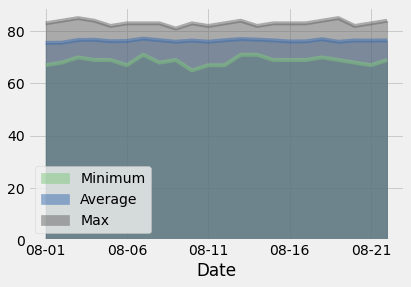

In [153]:
# Plot the daily normals as an area plot with `stacked=False`
normalsdf.plot.area(stacked=False, colormap="Accent")
plt.savefig("Images/Normals.png")
plt.show()

## Close Session

In [ ]:
session.close()